<a href="https://colab.research.google.com/github/Jihaad2021/Paractical_Keras/blob/main/Computer_Vision/03_Image_Classification_via_fine_tune_with_EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Loading data 
import tensorflow_datasets as tfds 

batch_size=64

dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(dataset_name, split=["train", "test"], with_info=True, as_supervised=True
                                         )
NUM_CLASSES = ds_info.features["label"].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete8POCHO/stanford_dogs-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete8POCHO/stanford_dogs-test.tfrecord*...:   0%…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [6]:
# Resize images
IMG_SIZE = 224 
size = (IMG_SIZE, IMG_SIZE) 
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))


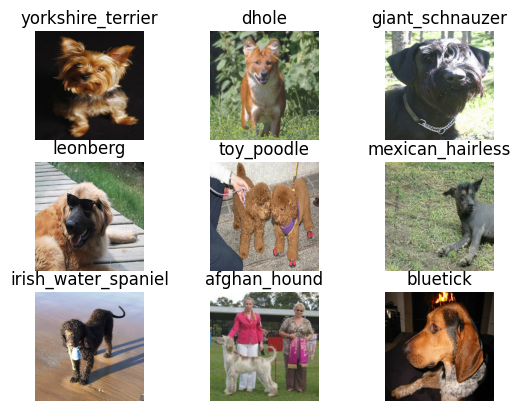

In [7]:
# Visualizing the data 
import matplotlib.pyplot as plt 

def format_label(label):
  string_label = label_info.int2str(label) 
  return string_label.split("-")[1] 

label_info = ds_info.features["label"] 
for i, (image, label) in enumerate(ds_train.take(9)):
  ax = plt.subplot(3, 3, i+1) 
  plt.imshow(image.numpy().astype("uint8")) 
  plt.title("{}".format(format_label(label)))
  plt.axis("off")

In [8]:
# Data augmentation 
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers 

img_augmentation = Sequential( 
    [ 
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1)
    ], 
    name="img_augmentation"
)

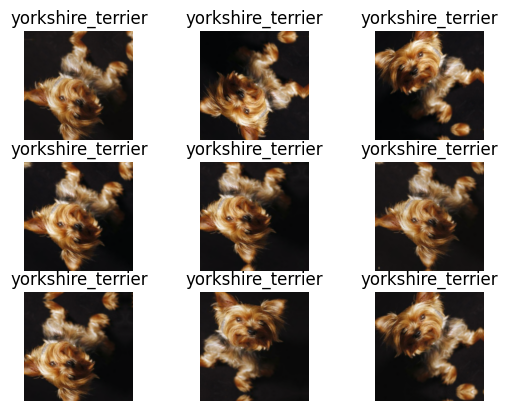

In [9]:
for image, label in ds_train.take(1):
  for i in range(9): 
    ax = plt.subplot(3,3, i+1)
    aug_img = img_augmentation(tf.expand_dims(image, axis=0))
    plt.imshow(aug_img[0].numpy().astype("uint8")) 
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

In [13]:
# Preparae inputs

# apply 'data augmentation' to the training images 
ds_train = ds_train.map(
    lambda img, label: (img_augmentation(img), label),
    num_parallel_calls = tf.data.AUTOTUNE,
)
# prefetching samples in gpu memory helps maximize GPU utilization
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [16]:
# Training a model from scratch 
from tensorflow.keras.applications import EfficientNetB0 

with strategy.scope(): 
  inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)) 
  x = img_augmentation(inputs) 
  outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(x)

  model = tf.keras.Model(inputs, outputs)
  model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

epochs = 5
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 img_augmentation (Sequentia  (None, 224, 224, 3)      0         
 l)                                                              
                                                                 
 efficientnetb0 (Functional)  (None, 120)              4203291   
                                                                 
Total params: 4,203,291
Trainable params: 4,161,268
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/5


KeyboardInterrupt: ignored

In [19]:
# Transfer learning from pre-trained weights 

def build_model(num_classes):
  inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
  x = img_augmentation(inputs) 
  model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

  # freze the pretrained weights 
  model.trainable = False 

  # Rebuild top 
  x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
  x = layers.BatchNormalization()(x)

  top_dropout_rate = 0.2
  x = layers.Dropout(top_dropout_rate, name="top_dropout")(x) 
  outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

  # compile 
  model = tf.keras.Model(inputs, outputs, name="EfficientNet")
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
  model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
                )
  return model


In [20]:
with strategy.scope():
  model = build_model(num_classes=NUM_CLASSES)

epochs = 25 
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)
plot_hist(hist)

Epoch 1/25


KeyboardInterrupt: ignored

In [21]:
# unfinish project fail to train